In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf

from pathlib import Path
from tensorflow.io import read_file
from tensorflow.image import decode_image
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.constraints import max_norm
from sklearn.model_selection import KFold
from keras.optimizers import Adam
from tensorflow.keras import activations, layers, optimizers, losses, Sequential
from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold


# Dataset

In [2]:
data_directory = pathlib.Path("/Users/margheritamenegazzi/Desktop/ML/Project/data") 

In [ ]:
# delete corrupted dog images

for image in sorted((data_directory/'Dogs').glob('*')):
    try:
        img = read_file(str(image))
        img = decode_image(img)
        
        if img.ndim != 3:
            print(f"[FILE_CORRUPT] {str(image).split('/')[-1]} DELETED")
            image.unlink()
            
    except Exception as e:
        print(f"[ERR] {str(image).split('/')[-1]}: {e} DELETED")
        image.unlink()

In [ ]:
# delete corrupted cat images

for image in sorted((data_directory/'Cats').glob('*')):
    try:
        img = read_file(str(image))
        img = decode_image(img)
        
        if img.ndim != 3:
            print(f"[FILE_CORRUPT] {str(image).split('/')[-1]} DELETED")
            image.unlink()
            
    except Exception as e:
        print(f"[ERR] {str(image).split('/')[-1]}: {e} DELETED")
        image.unlink()

In [3]:
pic_count = len(list(data_directory.glob("*/*.jpg")))
print(pic_count)

24940


In [4]:
batch_size = 42
img_height = 100
img_width = 100
color_mode='rgb'

In [5]:
# training set

train_data = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    color_mode=color_mode,
    validation_split=0.4,
    subset="training",
    seed=42,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


Found 24940 files belonging to 2 classes.
Using 14964 files for training.


In [6]:
# validation set

val_data = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    color_mode=color_mode,
    validation_split=0.4,
    subset="validation",
    seed=42,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 24940 files belonging to 2 classes.
Using 9976 files for validation.


In [7]:
# test set

val_len = len(val_data)
pcent = 0.16
tot_batches = int(val_len*pcent)
test_data = val_data.skip(tot_batches)
val_data = val_data.take(tot_batches)

In [8]:
# unbatch test data

test_data_1 = test_data.unbatch()
images_test = list(test_data_1.map(lambda x, y: x))
labels_test = list(test_data_1.map(lambda x, y: y))

print(len(labels_test))
print(len(images_test))


8380
8380


# Data Visualization

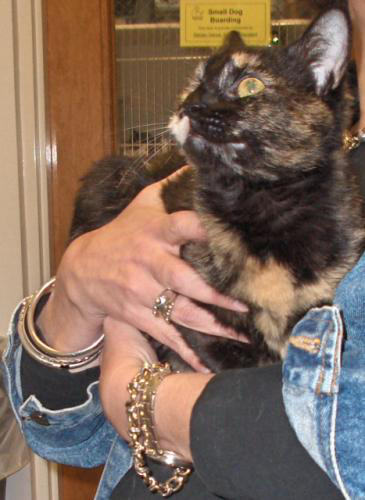

In [9]:
cats = list(data_directory.glob("Cats/*"))
PIL.Image.open(str(cats[0]))

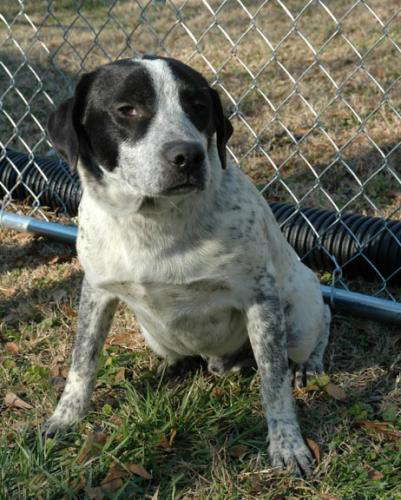

In [10]:
dogs = list(data_directory.glob("Dogs/*"))
PIL.Image.open(str(dogs[1]))

In [11]:
label_names = train_data.class_names
print(label_names)

['Cats', 'Dogs']


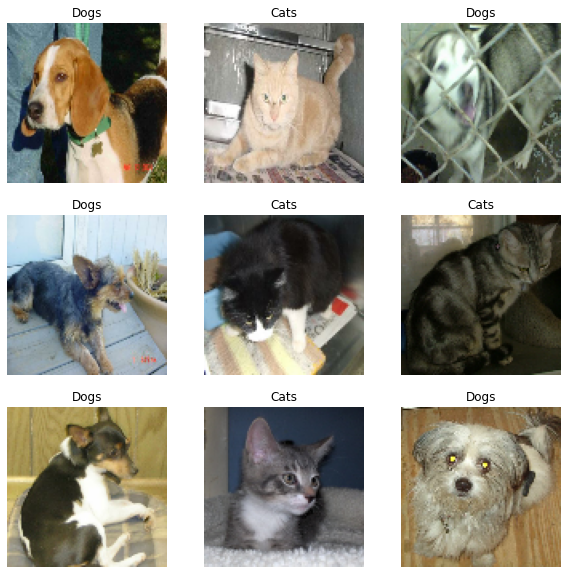

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
        plt.title(label_names[labels[i]])
        plt.axis("off")

In [13]:
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(42, 100, 100, 3)
(42,)


## Model 1: FeedForward NN

In [14]:
# model definition

model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='relu'),  
  layers.Dense(2),
       
])

In [15]:
# compile the model

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 128)               3840128   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3,844,322
Trainable params: 3,844,322
Non-trainable params: 0
_________________________________________________________________


In [17]:
# train the model

epochs=10
history = model_1.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/10
357/357 [==============================] - 33s 90ms/step - loss: 1.2562 - accuracy: 0.5424 - val_loss: 0.7803 - val_accuracy: 0.5501
Epoch 2/10
357/357 [==============================] - 34s 95ms/step - loss: 0.7228 - accuracy: 0.5776 - val_loss: 0.6650 - val_accuracy: 0.5783
Epoch 3/10
357/357 [==============================] - 36s 99ms/step - loss: 0.6685 - accuracy: 0.6004 - val_loss: 0.6464 - val_accuracy: 0.6341
Epoch 4/10
357/357 [==============================] - 36s 100ms/step - loss: 0.6503 - accuracy: 0.6194 - val_loss: 0.6870 - val_accuracy: 0.5946
Epoch 5/10
357/357 [==============================] - 34s 93ms/step - loss: 0.6609 - accuracy: 0.6093 - val_loss: 0.7026 - val_accuracy: 0.5658
Epoch 6/10
357/357 [==============================] - 35s 97ms/step - loss: 0.6515 - accuracy: 0.6167 - val_loss: 0.6525 - val_accuracy: 0.6190
Epoch 7/10
357/357 [==============================] - 35s 97ms/step - loss: 0.6563 - accuracy: 0.6111 - val_loss: 0.6572 - val_accuracy

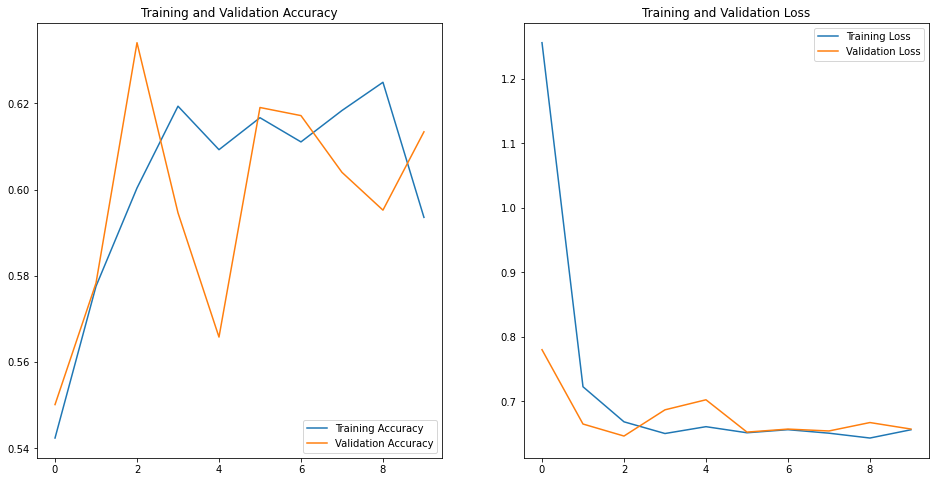

In [18]:
# plot accuracies and losses

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 2: Convolutional NN

In [19]:
# build the model

num_classes = len(label_names)

model_2 = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

In [20]:
# compile the model

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)       

In [22]:
# train the model

epochs=10
history = model_2.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/10
357/357 [==============================] - 116s 320ms/step - loss: 0.5988 - accuracy: 0.6665 - val_loss: 0.5330 - val_accuracy: 0.7262
Epoch 2/10
357/357 [==============================] - 119s 332ms/step - loss: 0.4853 - accuracy: 0.7698 - val_loss: 0.5140 - val_accuracy: 0.7450
Epoch 3/10
357/357 [==============================] - 117s 325ms/step - loss: 0.4243 - accuracy: 0.8051 - val_loss: 0.4187 - val_accuracy: 0.8089
Epoch 4/10
357/357 [==============================] - 114s 317ms/step - loss: 0.3633 - accuracy: 0.8337 - val_loss: 0.4309 - val_accuracy: 0.8076
Epoch 5/10
357/357 [==============================] - 110s 308ms/step - loss: 0.3075 - accuracy: 0.8665 - val_loss: 0.4199 - val_accuracy: 0.8177
Epoch 6/10
357/357 [==============================] - 110s 308ms/step - loss: 0.2437 - accuracy: 0.8958 - val_loss: 0.4844 - val_accuracy: 0.8058
Epoch 7/10
357/357 [==============================] - 110s 307ms/step - loss: 0.1835 - accuracy: 0.9245 - val_loss: 0.5250 -

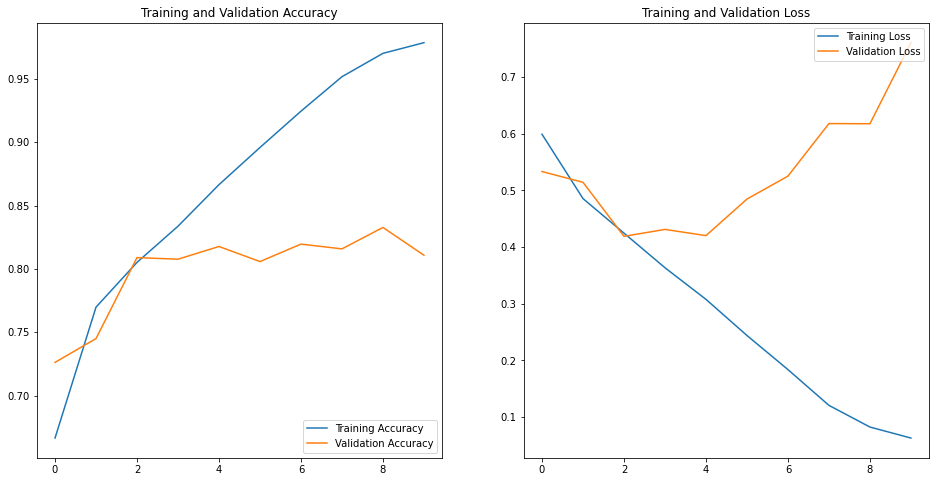

In [23]:
# plot accuracies and losses

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 3: Convolutional NN with Dropout Layers

In [24]:
# build the model

model_3 = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(rate= 0.2),  
  layers.Conv2D(32, 6, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(rate= 0.2),  
  layers.Conv2D(64, 9, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(rate= 0.2),  
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes),
])

In [25]:
# compile the model

model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 50, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

In [27]:
# train the model

epochs=10
history = model_3.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/10
357/357 [==============================] - 319s 887ms/step - loss: 0.6924 - accuracy: 0.5414 - val_loss: 0.6376 - val_accuracy: 0.6335
Epoch 2/10
357/357 [==============================] - 285s 797ms/step - loss: 0.6174 - accuracy: 0.6525 - val_loss: 0.6229 - val_accuracy: 0.6310
Epoch 3/10
357/357 [==============================] - 278s 778ms/step - loss: 0.5617 - accuracy: 0.7122 - val_loss: 0.5109 - val_accuracy: 0.7393
Epoch 4/10
357/357 [==============================] - 275s 770ms/step - loss: 0.5249 - accuracy: 0.7357 - val_loss: 0.5119 - val_accuracy: 0.7406
Epoch 5/10
357/357 [==============================] - 276s 771ms/step - loss: 0.4819 - accuracy: 0.7683 - val_loss: 0.4971 - val_accuracy: 0.7544
Epoch 6/10
357/357 [==============================] - 276s 772ms/step - loss: 0.4555 - accuracy: 0.7848 - val_loss: 0.4452 - val_accuracy: 0.7845
Epoch 7/10
357/357 [==============================] - 278s 778ms/step - loss: 0.4315 - accuracy: 0.7997 - val_loss: 0.4419 -

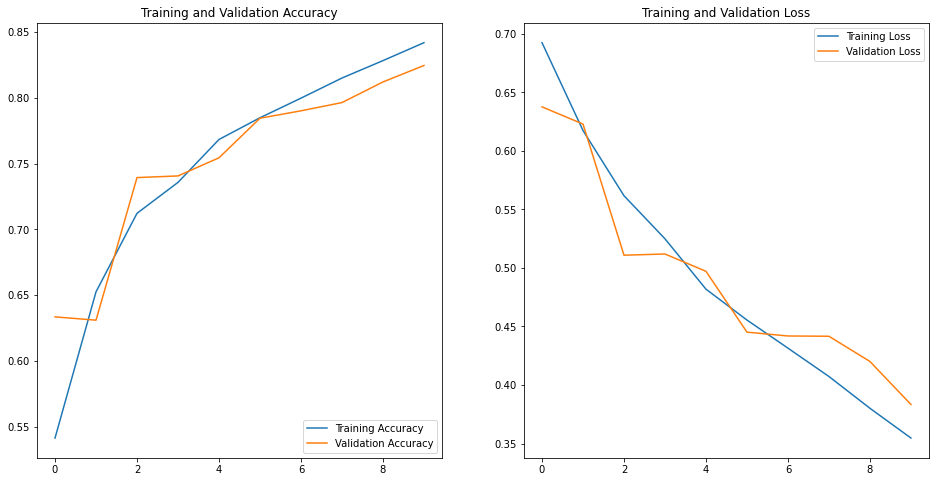

In [28]:
# plot accuracies and losses

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 5-Fold Cross Validation for Model 3

In [29]:
# Model configuration

input_shape = (100, 100, 3)
no_epochs = 40
verbosity = 1
fold_no = 5

In [30]:
# Define per-fold score containers

acc_per_fold = []
loss_per_fold = []


In [31]:
# Merge inputs and targets

inputs = images_test
targets = labels_test


In [34]:
# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=fold_no, shuffle = True)
kfold.get_n_splits(inputs, targets)

5

In [35]:
# K-fold Cross Validation model evaluation

for fold_no, (train_indexes, val_indexes) in enumerate(kfold.split(inputs, targets)):

    validation_data_X = np.array([inputs[idx].numpy() for idx in val_indexes])
    validation_data_y = np.array([targets[idx].numpy() for idx in val_indexes])
    training_data_X = np.array([inputs[idx].numpy() for idx in train_indexes])
    training_data_y = np.array([targets[idx].numpy() for idx in train_indexes])
    
    # Define the model architecture
    model_3 = Sequential([
      layers.Rescaling(1./255, input_shape=(100, 100, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(rate= 0.2),  
      layers.Conv2D(32, 6, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(rate= 0.2),  
      layers.Conv2D(64, 9, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(rate= 0.2),  
      layers.Flatten(),
      layers.Dense(128, activation='sigmoid'),
      layers.Dense(2),
    ])
    
    
    # Compile the model
    model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    
   # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

   # Fit data to model
    history = model_3.fit(
        x=training_data_X,
        y=training_data_y,
        epochs=no_epochs,
        verbose=1,
    )


   # Generate generalization metrics
    scores = model_3.evaluate(
        x=validation_data_X,
        y=validation_data_y,
        verbose=1,)
    print(f'Score for fold {fold_no}: {model_3.metrics_names[0]} of {scores[0]}; {model_3.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])


# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------') 
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1/40
210/210 [==============================] - 133s 630ms/step - loss: 0.7090 - accuracy: 0.5058
Epoch 2/40
210/210 [==============================] - 135s 643ms/step - loss: 0.6955 - accuracy: 0.5018
Epoch 3/40
210/210 [==============================] - 131s 626ms/step - loss: 0.6954 - accuracy: 0.5036
Epoch 4/40
210/210 [==============================] - 126s 600ms/step - loss: 0.6959 - accuracy: 0.4918
Epoch 5/40
210/210 [==============================] - 122s 582ms/step - loss: 0.6964 - accuracy: 0.4949
Epoch 6/40
210/210 [==============================] - 121s 576ms/step - loss: 0.6969 - accuracy: 0.4899
Epoch 7/40
210/210 [==============================] - 120s 574ms/step - loss: 0.6956 - accuracy: 0.4979
Epoch 8/40
210/210 [==============================] - 121s 576ms/step - loss: 0.6963 - accuracy: 0.4994
Epoch 9/40
210/210 [==============================] - 121s 574ms/step -

210/210 [==============================] - 120s 569ms/step - loss: 0.6949 - accuracy: 0.4849
Epoch 29/40
210/210 [==============================] - 119s 568ms/step - loss: 0.6955 - accuracy: 0.5070
Epoch 30/40
210/210 [==============================] - 120s 571ms/step - loss: 0.6960 - accuracy: 0.4990
Epoch 31/40
210/210 [==============================] - 120s 570ms/step - loss: 0.6952 - accuracy: 0.5061
Epoch 32/40
210/210 [==============================] - 119s 569ms/step - loss: 0.6983 - accuracy: 0.5016
Epoch 33/40
210/210 [==============================] - 120s 571ms/step - loss: 0.6969 - accuracy: 0.4942
Epoch 34/40
210/210 [==============================] - 120s 570ms/step - loss: 0.6965 - accuracy: 0.4951
Epoch 35/40
210/210 [==============================] - 120s 572ms/step - loss: 0.6958 - accuracy: 0.5088
Epoch 36/40
210/210 [==============================] - 120s 572ms/step - loss: 0.6960 - accuracy: 0.4969
Epoch 37/40
210/210 [==============================] - 121s 574ms/s